<a href="https://colab.research.google.com/github/kvame96/NOVIA/blob/main/%22Industrial_AI%22_Assignment2_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
%%capture
%reset -f

# OpenAI CLIP via Hugging Face
- Using a pre-trained CLIP model (available on Hugging Face Transformers) to generate embeddings for a ThermoSolar-PV image.
- Creation of textual descriptions for each of targetted ThermoSolar-PV image.
- Comparison or image and text embedding.

In [87]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import torch
import os
import random

# Load an image from my drive
# Dataset available in Kaggle: "https://www.kaggle.com/datasets/pkdarabi/solarpanel"
# The Dataset has already been augmented
# Detected anomalies of the dataset:
# 0. Single Hotspot
# 1. Multi Hotspots
# 2. Single Diode
# 3. Multi Diode
# 4. Single Bypassed Substring
# 5. Multi Bypassed Substring
# 6. String (Open Circuit)
# 7. String (Reversed Polarity)

# Load an image from the net
#url = "https://www.borealbirds.org/sites/default/files/bird_images/american-robin.JPG"
#image = Image.open(requests.get(url, stream=True).raw)

from google.colab import drive
drive.mount('/content/drive')
image_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/train/images/'           # adjust if needed: image path

# pick up a random image if you don't have a specific chosen one                                        # adjust if needed: random image
all_image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
random_image_name = random.choice(all_image_files)
image_file_path = os.path.join(image_path, random_image_name)

# pick up a chose image                                                                                  # adjust if needed: chosen image
#image_name = '-_png_jpg.rf.77c8b49942494cec5e5252f42607d6e2.jpg'
#image_file_path = image_path + image_name

image = Image.open(image_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


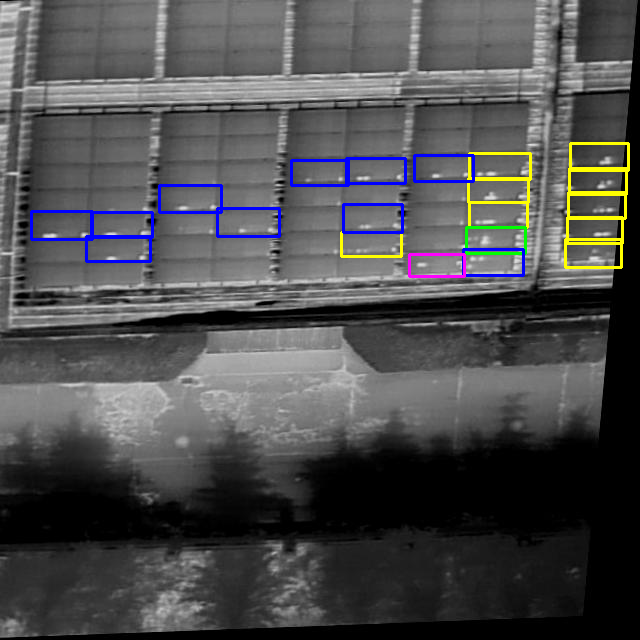



 <class_id>  <x_center>  <y_center>  <width>  <height>
          4    0.936403    0.244855 0.090232  0.041608
          4    0.934453    0.283895 0.088560  0.040001
          4    0.932611    0.321372 0.088560  0.040001
          4    0.929880    0.360434 0.087107  0.041518
          4    0.927367    0.396372 0.087216  0.043080
          4    0.780950    0.260293 0.094810  0.040182
          4    0.779109    0.297771 0.094700  0.038620
          4    0.778776    0.335984 0.091685  0.040091
          1    0.775209    0.375850 0.091685  0.040091
          2    0.771243    0.410271 0.093247  0.040137
          2    0.694232    0.262817 0.091685  0.040091
          5    0.682852    0.414402 0.086560  0.033705
          2    0.587872    0.267471 0.091575  0.038529
          4    0.580623    0.382292 0.093029  0.037012
          2    0.500372    0.270017 0.088560  0.040001
          2    0.297914    0.310992 0.096482  0.041790
          2    0.388151    0.347350 0.096591  0.043353
        

In [88]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load YOLOv9 annotations
# Extract the base name of the image (without extension)
image_id = random_image_name.rsplit('.', 1)[0]
# Construct the label file name
label_name = image_id + '.txt'
# Construct the full path to the label file
label_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/train/labels/'            # adjust if needed: label path
label_file_path = os.path.join(label_path, label_name)

# Define colors for each class
colors = {
    0: (0, 0, 255),   # Single Hotspot - Red
    1: (0, 255, 0),   # Multi Hotspots - Green
    2: (255, 0, 0),   # Single Diode - Blue
    3: (255, 255, 0), # Multi Diode - Cyan
    4: (0, 255, 255), # Single Bypassed Substring - Yellow
    5: (255, 0, 255), # Multi Bypassed Substring - Magenta
    6: (128, 0, 128), # String (Open Circuit) - Purple
    7: (128, 128, 0)  # String (Reversed Polarity) - Olive
}


try:
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
except FileNotFoundError:
    print(f"Error: Label file not found at {label_file_path}")
    exit()


image_np = np.array(image)
image_cv2 = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    class_id = int(class_id)

    h, w, _ = image_cv2.shape
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)

    color = colors.get(class_id, (255, 255, 255)) # Default to white if class not found
    cv2.rectangle(image_cv2, (x1, y1), (x2, y2), color, 2)


cv2_imshow(image_cv2)



################################################################################



# Display the faults of the Label YOLOv9 file:
import pandas as pd

# Assuming 'lines' variable from the provided code contains the YOLOv9 annotations
try:
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
except FileNotFoundError:
    print(f"Error: Label file not found at {label_file_path}")
    exit()

data = []
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    data.append([int(class_id), x_center, y_center, width, height])

df = pd.DataFrame(data, columns=['<class_id>', '<x_center>', '<y_center>', '<width>', '<height>'])

# Display the DataFrame without row numbers
print('\n')
print(df.to_string(index=False))


In [89]:
# Load the model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define possible labels                                                                                 # adjust if needed: text labels
text = ["a thermal photo of a ThermoSolar-PV with Single Hotspot failure",
        "a thermal photo of a ThermoSolar-PV with Multi Hotspots failures",
        "a thermal photo of a ThermoSolar-PV with Single Diode failures",
        "a thermal photo of a ThermoSolar-PV with Multi Diode failures",
        "a thermal photo of a ThermoSolar-PV with Single Bypassed Substring failures",
        "a thermal photo of a ThermoSolar-PV with Multi Bypassed Substring failures",
        "a thermal photo of a ThermoSolar-PV with String (Open Circuit) failures",
        "a thermal photo of a ThermoSolar-PV with String (Reversed Polarity) failures",]

# Process the inputs
inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

# Get prediction scores
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

# Show results
print('\n')
for label, prob in zip(text, probs[0]):
    print(f"{label}: {prob.item():.4f}")



a thermal photo of a ThermoSolar-PV with Single Hotspot failure: 0.1467
a thermal photo of a ThermoSolar-PV with Multi Hotspots failures: 0.1348
a thermal photo of a ThermoSolar-PV with Single Diode failures: 0.0812
a thermal photo of a ThermoSolar-PV with Multi Diode failures: 0.0652
a thermal photo of a ThermoSolar-PV with Single Bypassed Substring failures: 0.0560
a thermal photo of a ThermoSolar-PV with Multi Bypassed Substring failures: 0.0597
a thermal photo of a ThermoSolar-PV with String (Open Circuit) failures: 0.2281
a thermal photo of a ThermoSolar-PV with String (Reversed Polarity) failures: 0.2282


# Laion CLIP via Hugging Face

In [90]:
# Load the model and processor. Using last available version of laion (22 Jan 2025)
model_laion = CLIPModel.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")  # High-performance large model
processor_laion = CLIPProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

# Using the same 'image' and 'text' as for OpenAI CLIP

# Process the inputs
inputs = processor_laion(text=text, images=image, return_tensors="pt", padding=True)

# Get prediction scores
outputs_laion = model_laion(**inputs)
logits_per_image_laion = outputs_laion.logits_per_image
probs_laion = logits_per_image_laion.softmax(dim=1)

# Show results
print('\n')
for label, prob in zip(text, probs_laion[0]):
    print(f"{label}: {prob.item():.4f}")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]



a thermal photo of a ThermoSolar-PV with Single Hotspot failure: 0.0550
a thermal photo of a ThermoSolar-PV with Multi Hotspots failures: 0.0976
a thermal photo of a ThermoSolar-PV with Single Diode failures: 0.2875
a thermal photo of a ThermoSolar-PV with Multi Diode failures: 0.1518
a thermal photo of a ThermoSolar-PV with Single Bypassed Substring failures: 0.0665
a thermal photo of a ThermoSolar-PV with Multi Bypassed Substring failures: 0.0367
a thermal photo of a ThermoSolar-PV with String (Open Circuit) failures: 0.1249
a thermal photo of a ThermoSolar-PV with String (Reversed Polarity) failures: 0.1801


# YOLO - You Only Look Once
- real-time object detection algorithm

In [91]:
%%capture

!pip install ultralytics

from ultralytics import YOLO
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

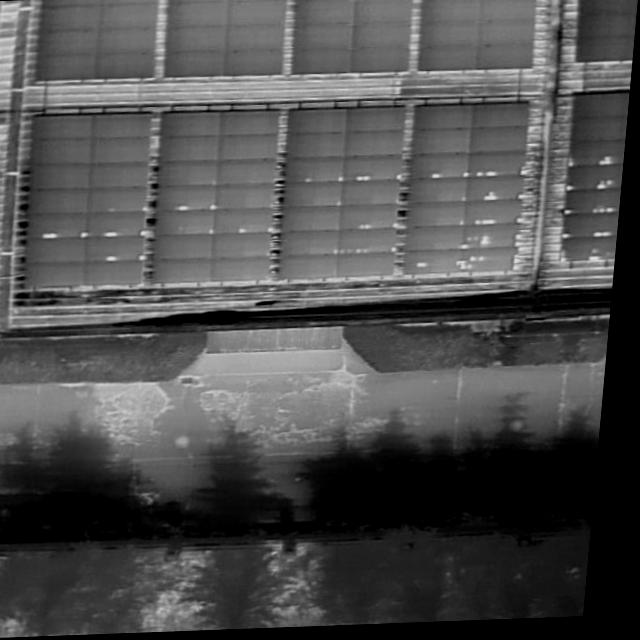

In [92]:
# prompt: can you build an anomaly detection code using YOLOv9, based on my previous code?
# Classes from 0 to 7 are anomalies. All objects are anomalies, i do not have healthy ones.
# Use the following format:
# from ultralytics import YOLO
# model = YOLO("yolov8s.pt")  # Load a small pre-trained model
# results = model("test.jpg")  # Detect objects
# results.show()  # Show image with boxes


# Load a pretrained YOLOv8n model
model = YOLO("yolov8n.pt")

# Perform object detection
full_image_path = image_path + random_image_name
results_YOLO = model(full_image_path)

# Anomalies are classes 0-7
anomaly_classes = list(range(8))  # List of classes considered anomalies

# Process the results
image = cv2.imread(full_image_path)
for result in results_YOLO:
    boxes = result.boxes
    for box in boxes:
        class_id = int(box.cls)
        confidence = box.conf
        if class_id in anomaly_classes and confidence > 0.5: # Adjust confidence as needed
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red bounding boxes for anomalies
            cv2.putText(image, f"Anomaly {class_id} ({confidence:.2f})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
# Display the image
cv2_imshow(image)

# Classification via Embeddings (k-NN, Logistic Regression, SVM, Random Forest)
- Extract CLIP embeddings and train my own classifier (e.g., k-NN, logistic regression, SVM, Random Forest).

In [93]:
%reset -f

In [ ]:
# ATTENTION !!!
# Do not execute this cell, it will take a long time.
# Instead, go to th next code cell and import the embeddings of X_train, y_train, X_test, y_test
# NOTE: I used the 'valid' dataset instead of the 'test' dataset due to the limited test dataset size.

################################################################################
# "Load and Embed Images"

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
import numpy as np

# Load model
model_id = "openai/clip-vit-base-patch32"  # or LAION model
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

# Function to extract embeddings
def get_image_embedding(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs)
        embedding = embedding / embedding.norm(p=2, dim=-1, keepdim=True)  # normalize
    return embedding.squeeze().cpu().numpy()

################################################################################
# Build The Trining Dataset

# Dataset structure:
# ImageSet/
#   ├── test/
#   │     ├── images
#   │     ├── label
#   ├── train/
#   │     ├── images
#   │     ├── label
#   └── valid/
#   │     ├── images
#   │     ├── label


import numpy as np
X_train = []  # embeddings
y_train = []  # labels (list of lists)

base_path = "/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/train"  # Update with the correct absolute path
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

for fname in os.listdir(images_path):
    if fname.endswith(".jpg"):
        image_path = os.path.join(images_path, fname)
        emb = get_image_embedding(image_path)
        X_train.append(emb)

        # Extract labels from corresponding YOLOv9 file
        label_file = os.path.join(labels_path, fname.rsplit('.', 1)[0] + ".txt")  # Adjust extension if needed
        image_labels = []  # List to store labels for this image
        try:
            with open(label_file, 'r') as f:
                for line in f:  # Iterate through all lines in the file
                    if line:  # Check if the line is not empty
                        label = int(line.split()[0])  # Extract the class ID
                        image_labels.append(label)
            y_train.append(image_labels)  # Append the list of labels for this image
        except FileNotFoundError:
            print(f"Warning: Label file not found for {fname}. Skipping this image.")

X_train = np.array(X_train)
# y_train is now a list of lists, and cannot be directly converted to a NumPy array

################################################################################
# Build The Testing Dataset

X_test = []  # embeddings
y_test = []  # labels (list of lists)

base_path = "/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/valid"
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

for fname in os.listdir(images_path):
    if fname.endswith(".jpg"):
        image_path = os.path.join(images_path, fname)
        emb = get_image_embedding(image_path)
        X_test.append(emb)

        # Extract labels from corresponding YOLOv9 file
        label_file = os.path.join(labels_path, fname.rsplit('.', 1)[0] + ".txt")
        image_labels = []  # List to store labels for this image
        try:
            with open(label_file, 'r') as f:
                for line in f:  # Iterate through all lines in the file
                    if line:  # Check if the line is not empty
                        label = int(line.split()[0])  # Extract the class ID
                        image_labels.append(label)
            y_test.append(image_labels)  # Append the list of labels for this image
        except FileNotFoundError:
            print(f"Warning: Label file not found for {fname}. Skipping this image.")

X_test = np.array(X_test)
# y_test is now a list of lists, and cannot be directly converted to a NumPy array


In [ ]:
# Save the Embeddings
#import pickle
#
#Train_Test_Embeddings = {
#    'X_train': X_train,
#    'y_train': y_train,
#    'X_test': X_test,
#    'y_test': y_test
#}
#
#with open('embeddings_data.pkl', 'wb') as f:
#    pickle.dump(Train_Test_Embeddings, f)

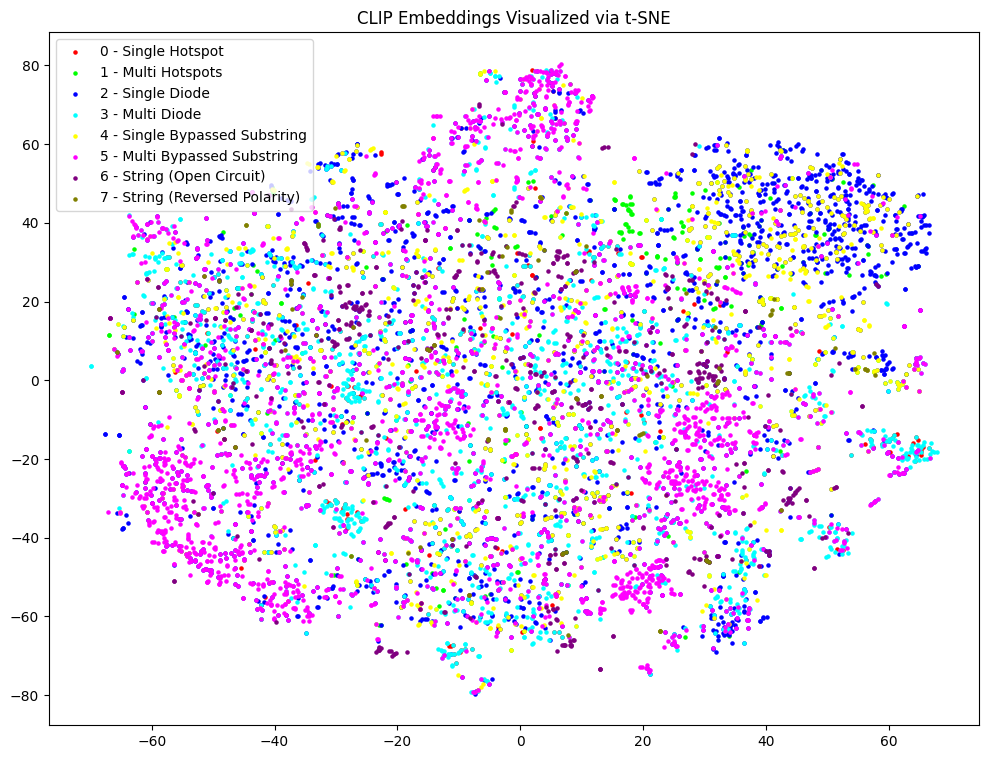

In [94]:
# Visualize embeddings using t-SNE

# Import the Embeddings
import pickle

file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/embeddings_data.pkl'
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']

################################################################################

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each class (adjust as needed)
colors = {
    0: (255, 0, 0),   # Single Hotspot - Red
    1: (0, 255, 0),   # Multi Hotspots - Green
    2: (0, 0, 255),   # Single Diode - Blue
    3: (0, 255, 255), # Multi Diode - Cyan
    4: (255, 255, 0), # Single Bypassed Substring - Yellow
    5: (255, 0, 255), # Multi Bypassed Substring - Magenta
    6: (128, 0, 128), # String (Open Circuit) - Purple
    7: (128, 128, 0)  # String (Reversed Polarity) - Olive
}

# Visualize embeddings using t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE
X_tsne = TSNE(n_components=2).fit_transform(X_train)

# Create a single plot
fig, ax = plt.subplots(figsize=(12, 9))  # Adjust figure size if needed

# Flatten y_train to get all unique labels
all_labels = [label for sublist in y_train for label in sublist]
unique_labels = np.unique(all_labels)

# Define class names
class_names = {
    0: '0 - Single Hotspot',
    1: '1 - Multi Hotspots',
    2: '2 - Single Diode',
    3: '3 - Multi Diode',
    4: '4 - Single Bypassed Substring',
    5: '5 - Multi Bypassed Substring',
    6: '6 - String (Open Circuit)',
    7: '7 - String (Reversed Polarity)'
}

# Plot t-SNE using unique labels with colors
for label in unique_labels:
    idxs = [i for i, sublist in enumerate(y_train) if label in sublist]
    color = colors.get(label, (0, 0, 0))  # Get color for the label

    # Normalize color tuple to 0-1 range
    color_normalized = tuple(c / 255.0 for c in color)

    ax.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], label=class_names.get(label, f'Class {label}'), s=5, c=[color_normalized])  # Set s for smaller dots, c for color

ax.legend()
ax.set_title("CLIP Embeddings Visualized via t-SNE")
plt.show()

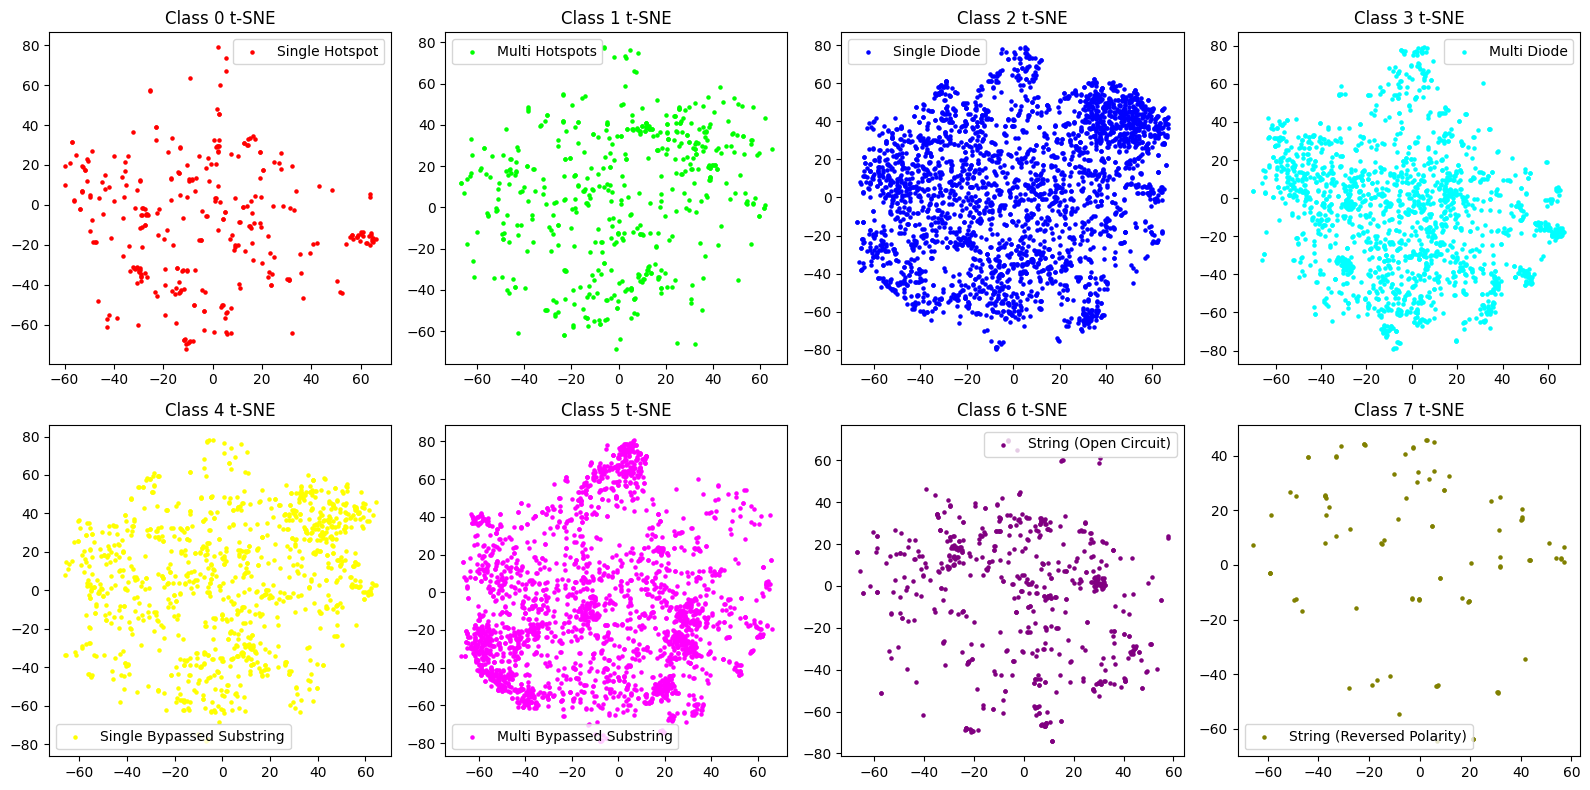

In [95]:
# Visualize embeddings using t-SNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE
X_tsne = TSNE(n_components=2).fit_transform(X_train)

# Create subplots for each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Adjust figure size if needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Flatten y_train to get all unique labels
all_labels = [label for sublist in y_train for label in sublist]
unique_labels = np.unique(all_labels)

# Define class names
class_names = {
    0: 'Single Hotspot',
    1: 'Multi Hotspots',
    2: 'Single Diode',
    3: 'Multi Diode',
    4: 'Single Bypassed Substring',
    5: 'Multi Bypassed Substring',
    6: 'String (Open Circuit)',
    7: 'String (Reversed Polarity)'
}

# Plot t-SNE for each class
for i, label in enumerate(unique_labels):
    idxs = [j for j, sublist in enumerate(y_train) if label in sublist]

    # Get color for the current label
    color = colors.get(label, (0, 0, 0))  # Default to black if not found

    # Normalize color tuple to 0-1 range
    color_normalized = tuple(c / 255.0 for c in color)

    axes[i].scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], label=class_names.get(label, f'Class {label}'), s=5, c=[color_normalized])  # Set s=5 for smaller dots, c for color
    axes[i].legend()
    axes[i].set_title(f"Class {label} t-SNE")

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.17      0.27        29
           1       0.47      0.21      0.29        39
           2       0.53      0.54      0.54       138
           3       0.58      0.40      0.47       142
           4       0.50      0.29      0.36        70
           5       0.55      0.48      0.51       122
           6       0.76      0.50      0.60        44
           7       0.00      0.00      0.00        14

   micro avg       0.56      0.41      0.47       598
   macro avg       0.50      0.32      0.38       598
weighted avg       0.55      0.41      0.46       598
 samples avg       0.49      0.43      0.43       598


Recall is equivalent to accuracy for a single class in multi-label classification


Overall Accuracy: 0.3875



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


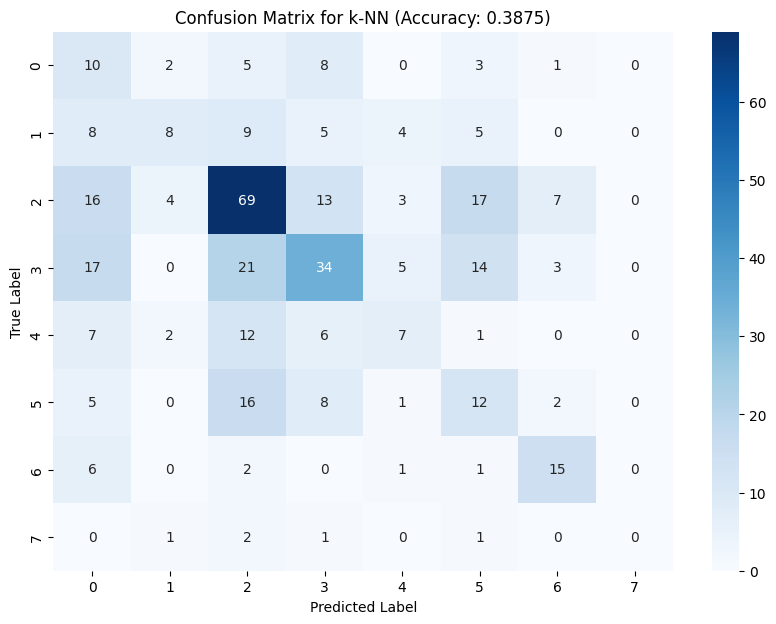

In [96]:
# k-NN
%reset -f

# Import the Embeddings
import pickle

file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/embeddings_data.pkl'
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']


################################################################################
# Train a Classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# k-NN or logistic regression
#clf = KNeighborsClassifier(n_neighbors=3)
clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=3))

# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Fit the binarizer to your training labels and transform them
y_train_binarized = mlb.fit_transform(y_train)

# Transform your test labels using the same binarizer
y_test_binarized = mlb.transform(y_test)

# Now, fit the classifier using the binarized labels
clf.fit(X_train, y_train_binarized)

# Predict
y_pred_kNN = clf.predict(X_test)

# If you need to convert the predictions back to the original label format:
y_pred_original = mlb.inverse_transform(y_pred_kNN)


################################################################################
# Display the Confusion Matrix

# Convert mlb.classes_ to a list of strings
target_names = [str(cls) for cls in mlb.classes_] # Convert to list of strings

# Print the modified classification report using target_names
print("\nClassification Report:")
print(classification_report(y_test_binarized, y_pred_kNN, target_names=target_names))


print()
print('Recall is equivalent to accuracy for a single class in multi-label classification')
print()
# Confusion Matrix and Accuracy

# Calculate accuracy
accuracy = accuracy_score(y_test_binarized.argmax(axis=1), y_pred_kNN.argmax(axis=1))
print(f"\nOverall Accuracy: {accuracy:.4f}")
print()

# Create the confusion matrix
cm_kNN = confusion_matrix(y_test_binarized.argmax(axis=1), y_pred_kNN.argmax(axis=1))

# Display the confusion matrix with colors using seaborn and accuracy in the title
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm_kNN, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_) # Use mlb.classes_ here
plt.title(f"Confusion Matrix for k-NN (Accuracy: {accuracy:.4f})") # Include accuracy in title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        39
           2       0.48      0.48      0.48       138
           3       0.55      0.13      0.21       142
           4       0.00      0.00      0.00        70
           5       0.63      0.18      0.28       122
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        14

   micro avg       0.52      0.18      0.26       598
   macro avg       0.21      0.10      0.12       598
weighted avg       0.37      0.18      0.22       598
 samples avg       0.24      0.17      0.19       598


Recall is equivalent to accuracy for a single class in multi-label classification


Overall Accuracy: 0.2250



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


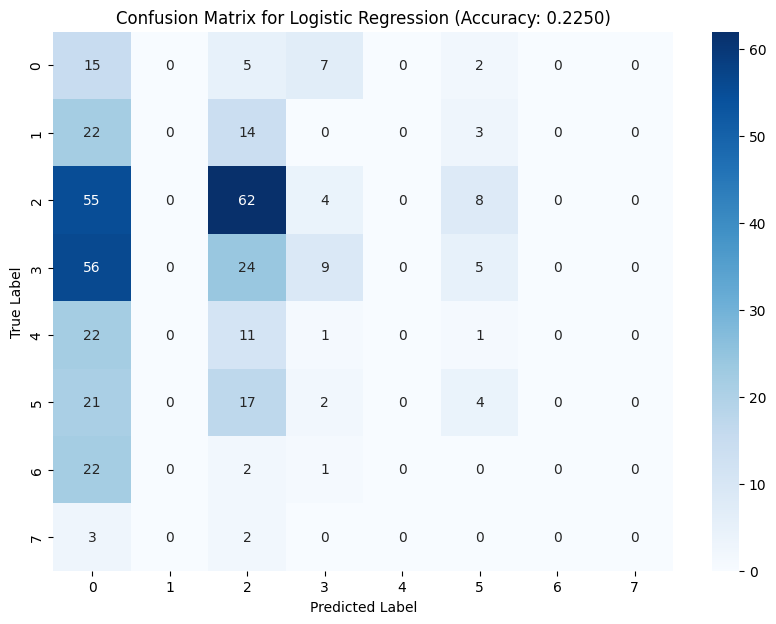

In [97]:
# Logistic Regression

%reset -f

# Import the Embeddings
import pickle

file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/embeddings_data.pkl'
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']


################################################################################
# Train a Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Logistic Regression
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000)) # Increased max_iter

# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Fit the binarizer to your training labels and transform them
y_train_binarized = mlb.fit_transform(y_train)

# Transform your test labels using the same binarizer
y_test_binarized = mlb.transform(y_test)

# Now, fit the classifier using the binarized labels
clf.fit(X_train, y_train_binarized)

# Predict
y_pred_LR = clf.predict(X_test) # Changed variable name

# If you need to convert the predictions back to the original label format:
y_pred_original = mlb.inverse_transform(y_pred_LR) # Changed variable name


################################################################################
# Display the Confusion Matrix

# Convert mlb.classes_ to a list of strings
target_names = [str(cls) for cls in mlb.classes_] # Convert to list of strings

# Print the modified classification report using target_names
print("\nClassification Report:")
print(classification_report(y_test_binarized, y_pred_LR, target_names=target_names)) # Changed variable name


print()
print('Recall is equivalent to accuracy for a single class in multi-label classification')
print()
# Confusion Matrix and Accuracy

# Calculate accuracy
accuracy = accuracy_score(y_test_binarized.argmax(axis=1), y_pred_LR.argmax(axis=1)) # Changed variable name
print(f"\nOverall Accuracy: {accuracy:.4f}")
print()

# Create the confusion matrix
cm_LR = confusion_matrix(y_test_binarized.argmax(axis=1), y_pred_LR.argmax(axis=1)) # Changed variable name

# Display the confusion matrix with colors using seaborn and accuracy in the title
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_) # Use mlb.classes_ here
plt.title(f"Confusion Matrix for Logistic Regression (Accuracy: {accuracy:.4f})") # Include accuracy in title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        39
           2       0.57      0.47      0.52       138
           3       0.79      0.08      0.14       142
           4       0.00      0.00      0.00        70
           5       0.78      0.20      0.32       122
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        14

   micro avg       0.63      0.17      0.27       598
   macro avg       0.27      0.09      0.12       598
weighted avg       0.48      0.17      0.22       598
 samples avg       0.24      0.17      0.19       598


Recall is equivalent to accuracy for a single class in multi-label classification


Overall Accuracy: 0.2450



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


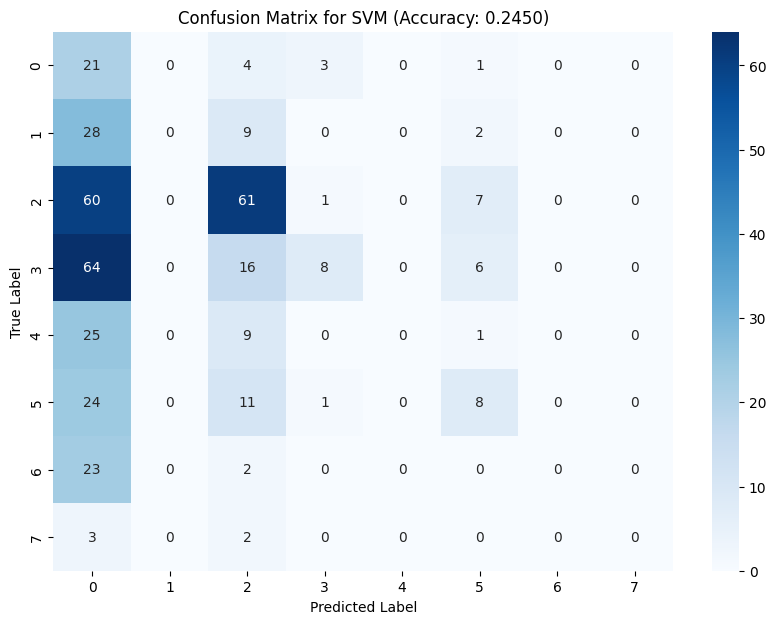

In [98]:
# SVM
%reset -f

# Import the Embeddings
import pickle

file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/embeddings_data.pkl'
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']


################################################################################
# Train a Classifier

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# SVM
clf = MultiOutputClassifier(SVC())

# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Fit the binarizer to your training labels and transform them
y_train_binarized = mlb.fit_transform(y_train)

# Transform your test labels using the same binarizer
y_test_binarized = mlb.transform(y_test)

# Now, fit the classifier using the binarized labels
clf.fit(X_train, y_train_binarized)

# Predict
y_pred_SVM = clf.predict(X_test)

# If you need to convert the predictions back to the original label format:
y_pred_original = mlb.inverse_transform(y_pred_SVM)


################################################################################
# Display the Confusion Matrix

# Convert mlb.classes_ to a list of strings
target_names = [str(cls) for cls in mlb.classes_] # Convert to list of strings

# Print the modified classification report using target_names
print("\nClassification Report:")
print(classification_report(y_test_binarized, y_pred_SVM, target_names=target_names))


print()
print('Recall is equivalent to accuracy for a single class in multi-label classification')
print()
# Confusion Matrix and Accuracy

# Calculate accuracy
accuracy = accuracy_score(y_test_binarized.argmax(axis=1), y_pred_SVM.argmax(axis=1))
print(f"\nOverall Accuracy: {accuracy:.4f}")
print()

# Create the confusion matrix
cm_SVM = confusion_matrix(y_test_binarized.argmax(axis=1), y_pred_SVM.argmax(axis=1))

# Display the confusion matrix with colors using seaborn and accuracy in the title
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm_SVM, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_) # Use mlb.classes_ here
plt.title(f"Confusion Matrix for SVM (Accuracy: {accuracy:.4f})") # Include accuracy in title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        39
           2       0.50      0.42      0.46       138
           3       0.65      0.12      0.20       142
           4       0.00      0.00      0.00        70
           5       0.74      0.16      0.27       122
           6       1.00      0.07      0.13        44
           7       0.00      0.00      0.00        14

   micro avg       0.57      0.16      0.25       598
   macro avg       0.36      0.10      0.13       598
weighted avg       0.50      0.16      0.22       598
 samples avg       0.23      0.17      0.19       598


Recall is equivalent to accuracy for a single class in multi-label classification


Overall Accuracy: 0.2200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


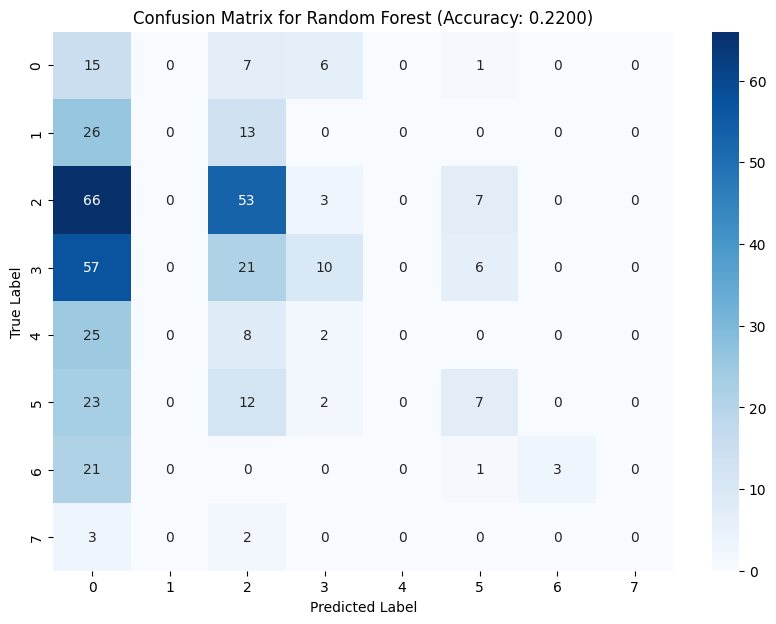

In [99]:
# Random Forest
%reset -f

# Import the Embeddings
import pickle

file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/embeddings_data.pkl'
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

X_train = loaded_data['X_train']
y_train = loaded_data['y_train']
X_test = loaded_data['X_test']
y_test = loaded_data['y_test']


################################################################################
# Train a Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Random Forest Classifier
clf = MultiOutputClassifier(RandomForestClassifier())

# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Fit the binarizer to your training labels and transform them
y_train_binarized = mlb.fit_transform(y_train)

# Transform your test labels using the same binarizer
y_test_binarized = mlb.transform(y_test)

# Now, fit the classifier using the binarized labels
clf.fit(X_train, y_train_binarized)

# Predict
y_pred_RF = clf.predict(X_test)

# If you need to convert the predictions back to the original label format:
y_pred_original = mlb.inverse_transform(y_pred_RF)


################################################################################
# Display the Confusion Matrix

# Convert mlb.classes_ to a list of strings
target_names = [str(cls) for cls in mlb.classes_] # Convert to list of strings

# Print the modified classification report using target_names
print("\nClassification Report:")
print(classification_report(y_test_binarized, y_pred_RF, target_names=target_names))


print()
print('Recall is equivalent to accuracy for a single class in multi-label classification')
print()
# Confusion Matrix and Accuracy

# Calculate accuracy
accuracy = accuracy_score(y_test_binarized.argmax(axis=1), y_pred_RF.argmax(axis=1))
print(f"\nOverall Accuracy: {accuracy:.4f}")
print()

# Create the confusion matrix
cm_RF = confusion_matrix(y_test_binarized.argmax(axis=1), y_pred_RF.argmax(axis=1))

# Display the confusion matrix with colors using seaborn and accuracy in the title
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_) # Use mlb.classes_ here
plt.title(f"Confusion Matrix for Random Forest (Accuracy: {accuracy:.4f})") # Include accuracy in title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ResNet50 with Pytorch (Multi Label Classification)

In [ ]:
# ResNet50 with Pytorch (Multi Label Classification)
%%capture
%reset -f

################################################################################

from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import os
from PIL import Image
from collections import Counter
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [ ]:
# Custom Dataset for YOLOv9 Multi-Label

################################################################################

# ATTENTION !!!
# The code takes 2 hours to be executed.

################################################################################

# Assuming the dataset structure:
# ImageSet/
#   ├── train/
#   │     ├── images
#   │     ├── labels
#   └── valid/
#   │     ├── images
#   │     ├── labels

class YOLOMultiLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, class_count, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.class_count = class_count
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        label_path = os.path.join(self.label_dir, image_filename.replace('.jpg', '.txt'))

        image = Image.open(image_path).convert("RGB")

        # Multi-hot vector for multi-labels
        label_vector = torch.zeros(self.class_count)
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_id = int(parts[0])
                        if 0 <= class_id < self.class_count:
                            label_vector[class_id] = 1
        except FileNotFoundError:
            pass  # No label file = assume no object

        if self.transform:
            image = self.transform(image)

        return image, label_vector

################################################################################

# Transforms & Dataloaders

NUM_CLASSES = 8
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = YOLOMultiLabelDataset(
    image_dir='/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/train/images',
    label_dir='/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/train/labels',
    class_count=NUM_CLASSES,
    transform=transform
)

val_dataset = YOLOMultiLabelDataset(
    image_dir='/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/valid/images',
    label_dir='/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/valid/labels',
    class_count=NUM_CLASSES,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)  # Adjust num_workers based on your system
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)  # Adjust num_workers based on your system

################################################################################

# Define Model with ResNet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# Freeze base layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer with 8-class sigmoid output
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, NUM_CLASSES),
    nn.Sigmoid()
)

model = model.to(device)

################################################################################

# Define Loss and Optimizer

criterion = nn.BCELoss()  # Binary Cross Entropy Loss for multi-label
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

################################################################################

# Training Loop

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {running_loss / len(train_loader):.4f}")

################################################################################

# Evaluation (Threshold Predictions)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()\

print(f"Validation Accuracy (multi-label match rate): {100 * correct / total:.2f}%")


In [ ]:
# Save the variables

#import pickle
#
#variables_to_save = {
#    'NUM_CLASSES': NUM_CLASSES,
#    'BATCH_SIZE': BATCH_SIZE,
#    'transform': transform,
#    'train_dataset': train_dataset,
#    'val_dataset': val_dataset,
#    'train_loader': train_loader,
#    'val_loader': val_loader,
#    'device': device,
#    'model': model,
#    'criterion': criterion,
#    'optimizer': optimizer,
#    'EPOCHS': EPOCHS,
#    'running_loss': running_loss,
#    'correct': correct,
#    'total': total,
#    'predicted': predicted
#}
#
#with open('ResNet50_via_Pytorch.pkl', 'wb') as f:
#  pickle.dump(variables_to_save, f)


# YOLOv9 model (part of an End to End model developed with FastAPI)

In [100]:
 %reset -f

 from google.colab import drive
 drive.mount('/content/drive')

 # Define the path to your file in Google Drive
 file_path = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
%%capture
!pip install ultralytics
from ultralytics import YOLO

model = YOLO(file_path + "SolarPanelsDefectDetector-master/ThermalDetector/Th_G_v9.pt")

In [102]:
# predictor.py
import numpy as np
from PIL import Image, ExifTags
import cv2
from io import BytesIO
#from model_loader import model

def preprocess_image(img: Image.Image) -> np.ndarray:
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None:
            orientation = exif.get(orientation)
            if orientation == 3:
                img = img.rotate(180, expand=True)
            elif orientation == 6:
                img = img.rotate(270, expand=True)
            elif orientation == 8:
                img = img.rotate(90, expand=True)
    except:
        pass

    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (640, 640))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    return img.astype(np.float32)

def run_inference(img: Image.Image):
    pre_img = preprocess_image(img)
    uint_img = (pre_img * 255).astype(np.uint8)
    pil_img = Image.fromarray(uint_img)

    results = model(pil_img)

    if not results or len(results) == 0:
        return [], "No anomalies", None

    detections = []
    for r in results:
        if r.boxes is None:
            continue
        for idx in range(len(r.boxes.xyxy)):
            if r.boxes.conf[idx] > 0.5:
                detections.append({
                    "class_id": int(r.boxes.cls[idx]),
                    "confidence": float(r.boxes.conf[idx]),
                    "xyxyn": r.boxes.xyxyn[idx].cpu().numpy().tolist()
                })

    output_image_np = results[0].plot()
    output_image_rgb = cv2.cvtColor(output_image_np, cv2.COLOR_BGR2RGB)
    output_image_pil = Image.fromarray(output_image_rgb)

    return detections, "Success", output_image_pil

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing image: 0raw_data_total_dataset_DJI_20230809115641_0004_T_jpg.rf.9bb957a3d9305cda271437cf80d2d6ae.jpg
Status: Success
Detections:
{'class_id': 2, 'confidence': 0.8562051057815552, 'xyxyn': [0.5089110136032104, 0.402263343334198, 0.5702112913131714, 0.554481029510498]}
{'class_id': 6, 'confidence': 0.8008318543434143, 'xyxyn': [0.2534974217414856, 0.5627869367599487, 0.31172648072242737, 0.6714442372322083]}
{'class_id': 2, 'confidence': 0.7323257327079773, 'xyxyn': [0.38410958647727966, 0.4022830128669739, 0.4439353942871094, 0.553909957408905]}
{'class_id': 6, 'confidence': 0.7074485421180725, 'xyxyn': [0.009089881554245949, 0.5631095170974731, 0.06509517133235931, 0.7080262303352356]}
{'class_id': 6, 'confidence': 0.646386981010437, 'xyxyn': [0.5723458528518677, 0.5599778890609741, 0.6319791078567505, 0.7102052569389343]}
{'class_id': 6, 'confide

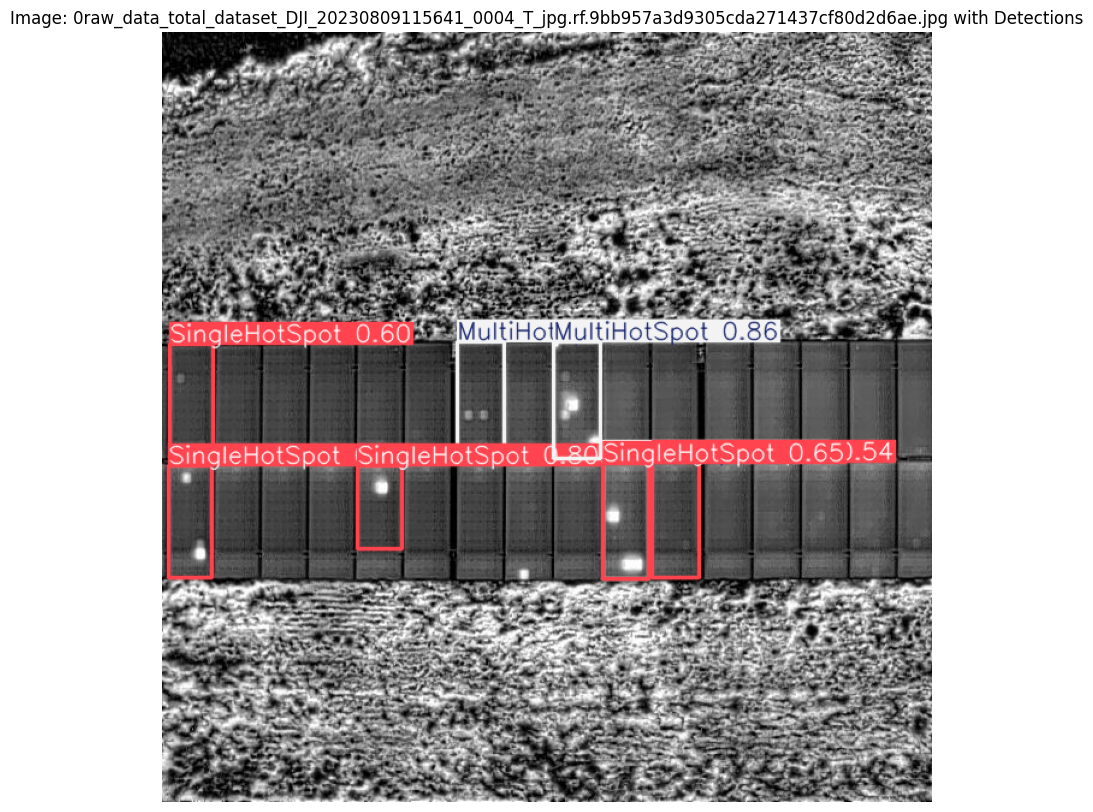


Processing image: 1132_jpg.rf.ce94953d7135d3bf4a243ff2361e3ca7.jpg
Status: Success
Detections:
{'class_id': 2, 'confidence': 0.8853346705436707, 'xyxyn': [0.06721258163452148, 0.8832120895385742, 0.11525833606719971, 0.9392141103744507]}
{'class_id': 4, 'confidence': 0.8085240125656128, 'xyxyn': [0.33448758721351624, 0.5648496747016907, 0.37719234824180603, 0.6154075860977173]}


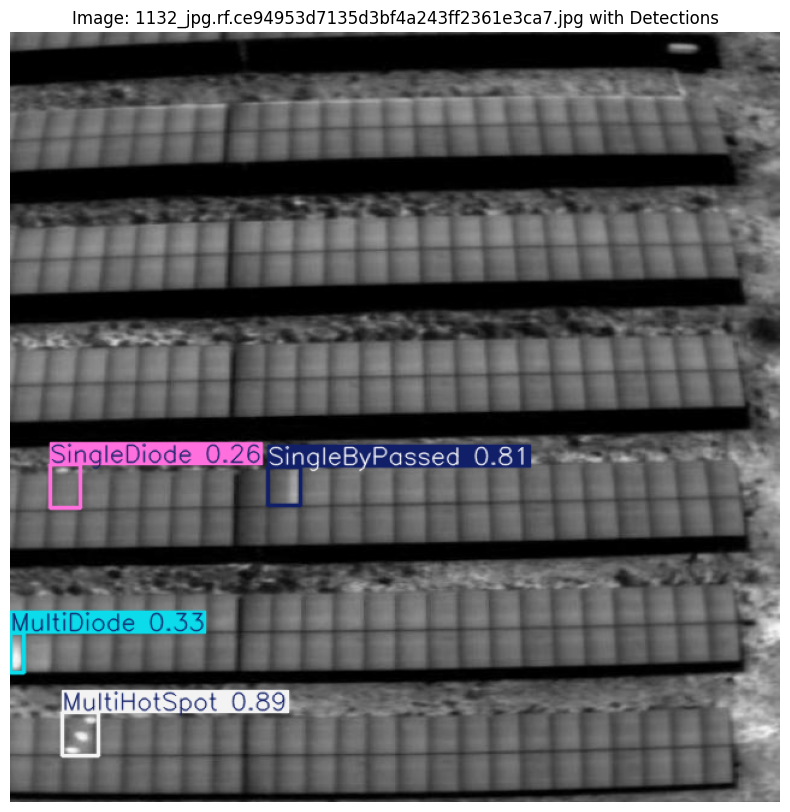


Processing image: 101MEDIA_DJI_0197_T_JPG_jpg.rf.14a614a870c515a925234c85d9f7b149.jpg
Status: Success
Detections:
{'class_id': 5, 'confidence': 0.5999249219894409, 'xyxyn': [0.2620178163051605, 0.1439962089061737, 0.4247964024543762, 0.26027005910873413]}


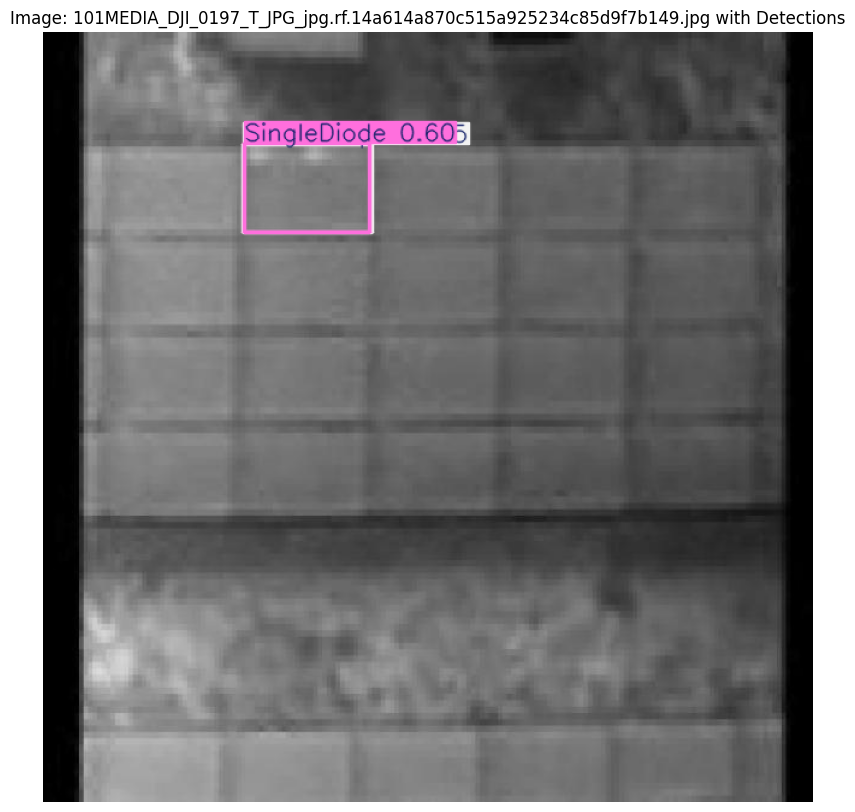


Processing image: 1105_jpg.rf.5b935e7c4eb35ac4990b996637923b46.jpg
Status: Success
Detections:
{'class_id': 2, 'confidence': 0.8591173887252808, 'xyxyn': [0.24679777026176453, 0.007435583975166082, 0.28518766164779663, 0.06491591781377792]}
{'class_id': 2, 'confidence': 0.7777601480484009, 'xyxyn': [0.2755531072616577, 0.17095109820365906, 0.3125358819961548, 0.22817447781562805]}


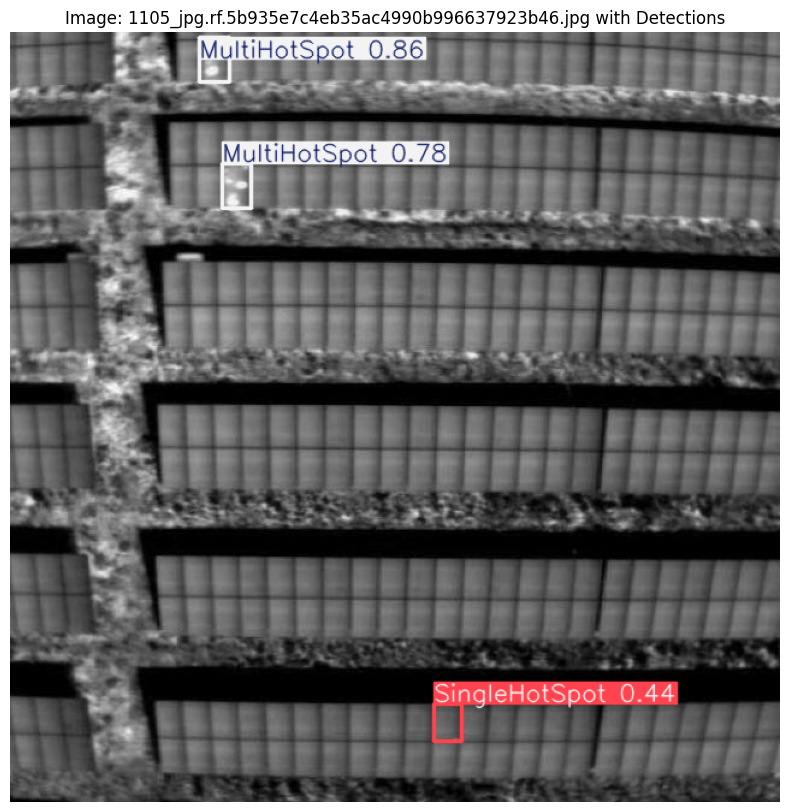


Processing image: 0raw_data_total_dataset_DJI_20230809115909_0006_T_jpg.rf.496aa274c335d5a336a314e127e2a5fa.jpg
Status: Success
Detections:
{'class_id': 0, 'confidence': 0.6427704095840454, 'xyxyn': [0.4731067717075348, 0.5194072723388672, 0.5327579379081726, 0.670734703540802]}


KeyboardInterrupt: 

In [103]:
from google.colab import drive
from PIL import Image
#from predictor import run_inference
import os
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Path to your validation images directory
image_dir = '/content/drive/My Drive/Novia/Industrial_AI/Assignment2/ImageSet/valid/images'

# Get a list of all files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Process each image
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    try:
        img = Image.open(image_path).convert('RGB')
        detections, status, output_image = run_inference(img)

        print(f"\nProcessing image: {image_file}")
        print(f"Status: {status}")

        if detections:
            print("Detections:")
            for detection in detections:
                print(detection)

            if output_image:
                plt.figure(figsize=(10, 10))
                plt.imshow(output_image)
                plt.title(f"Image: {image_file} with Detections")
                plt.axis('off')
                plt.show()
        else:
            print("No anomalies detected.")

    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing {image_file}: {e}")

print("\nInference complete for all images in the directory.")